In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import random
from tqdm import tqdm
import numpy as np
from GRUnet import InitGRU, KalmanNetNN

Importing dataset took 14.611371040344238 seconds
Number of all 0 columns: 0
Running EM algorithm...


EM iteration: 100%|█████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


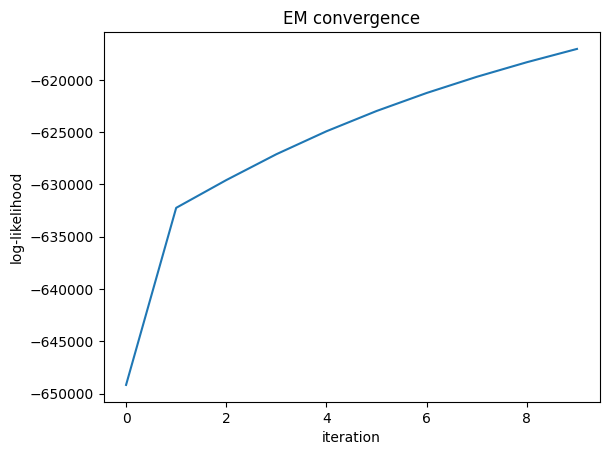

EM algorithm finished in 20.327436923980713 seconds
Calculating Latent States...
Prediction finished in 1.9900527000427246 seconds
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step ahead prediction...
Running One step a

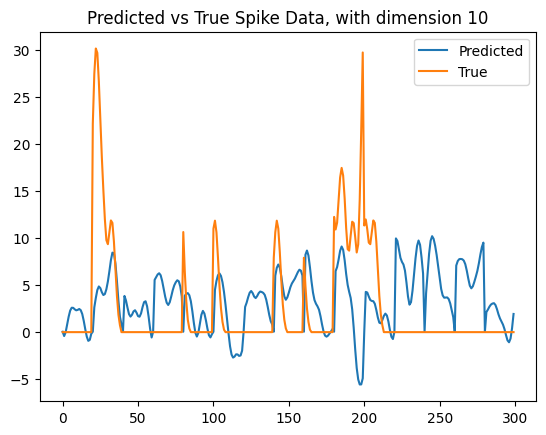

Calculating Latent States...
Prediction finished in 1.7324409484863281 seconds
Calculating Latent States...
Prediction finished in 0.018892765045166016 seconds
Calculating Latent States...
Prediction finished in 0.018884897232055664 seconds
Calculating Latent States...
Prediction finished in 0.0159151554107666 seconds
Calculating Latent States...
Prediction finished in 0.01723003387451172 seconds
Calculating Latent States...
Prediction finished in 0.01579117774963379 seconds
Calculating Latent States...
Prediction finished in 0.01876997947692871 seconds
Calculating Latent States...
Prediction finished in 0.015563011169433594 seconds
Calculating Latent States...
Prediction finished in 0.017642974853515625 seconds
Calculating Latent States...
Prediction finished in 0.014741182327270508 seconds
Calculating Latent States...
Prediction finished in 0.016662120819091797 seconds
Calculating Latent States...
Prediction finished in 0.01794290542602539 seconds
Calculating Latent States...
Predict

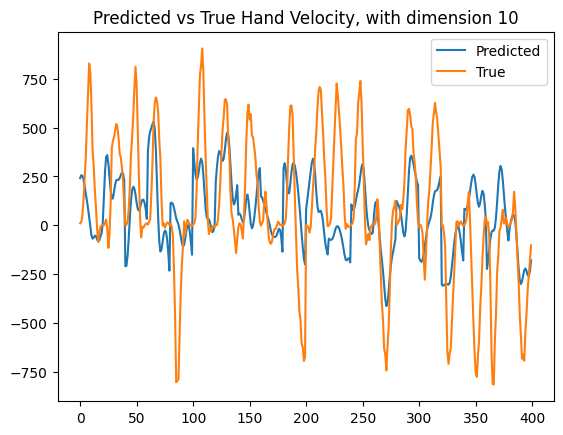

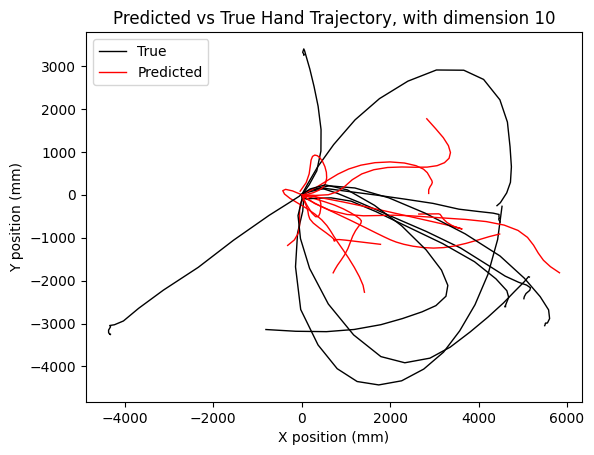

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from util import import_dataset, get_spikes_and_velocity, pre_process_spike, get_surrogate_data, plot_hand_trajectory
from EM import em_core

if __name__ == '__main__':
    train_dataset = import_dataset('Jenkins_train.nwb')

    train_spikes, train_velocity = get_spikes_and_velocity(train_dataset, resample_size=5, smooth=True)

    train_spikes, train_velocity = pre_process_spike(train_spikes, train_velocity, train_dataset,
                                                     window_step=5, overlap=False, window_size=15, smooth=False)

    # TODO: Examine the PSTHs

    # TODO: Plot PSTHs

    # Calculate EM #TODO: TEMPORARY CODE
    # 1) Generate surrogate data
    # 2) Run EM
    # 3) Predict latent states
    # 4) Predict hand velocity

    X, X_test, Y, Y_test = get_surrogate_data(train_spikes, train_velocity, trials=100)

    # Run EM
    mses = []

    EM_class = em_core(X, n_dim=10, n_iters=10)
    EM_class.get_parameters(plot=True)

    # TODO: Calculate Latent States for training data and plot to see grouping

    # Predict latent states
    latent_states = EM_class.cal_latent_states(X_test, current=False)

    # One step ahead prediction for spike data
    back_predict = np.array([EM_class.get_one_step_ahead_prediction(latent_states[i])
                             for i in range(len(latent_states))])

    # Combine all trials for back_predict and X_test
    back_predict_con = np.array([back_predict[i] for i in range(len(back_predict))])
    back_predict_con = back_predict_con.reshape(-1, back_predict_con.shape[-1])
    X_test_con = np.array([X_test[i] for i in range(len(X_test))])
    X_test_con = X_test_con.reshape(-1, X_test_con.shape[-1])

    # Plot back_predict and True value
    plt.figure()
    plt.plot(back_predict_con[:300, 0], label='Predicted')
    plt.plot(X_test_con[:300, 0], label='True')
    plt.title('Predicted vs True Spike Data, with dimension ' + str(EM_class.n_dim))
    plt.legend()
    plt.show()

    EM_class.fit(X, Y)

    # Predict the hand velocity
    hand_velocity = np.array([EM_class.predict_move(X_test[i]) for i in range(X_test.shape[0])])

    # Calculate RMSE
    rmse = np.sqrt(np.mean((X_test - back_predict) ** 2))
    print('NRMSE for spike data:', rmse)

    # Calculate RMSE for velocity
    rmse_vel = np.sqrt(np.mean((hand_velocity - Y_test) ** 2))/np.sqrt(np.var(Y_test))
    print('NRMSE for velocity:', rmse_vel)

    # Calculate MSE for a randomized shuffled trial version of hand_velocity
    rmse_vel_shuffled = np.sqrt(np.mean((np.random.permutation(hand_velocity) - Y_test) ** 2))/np.sqrt(np.var(Y_test))
    print('NRMSE for shuffled velocity:', rmse_vel_shuffled)

    # Combine all trials for hand_velocity and Y_test
    hand_velocity_con = np.array([hand_velocity[i] for i in range(len(hand_velocity) // 2)])
    hand_velocity_con = hand_velocity_con.reshape(-1, hand_velocity_con.shape[-1])
    Y_test_con = np.array([Y_test[i] for i in range(len(Y_test) // 2)])
    Y_test_con = Y_test_con.reshape(-1, Y_test_con.shape[-1])

    # Plot hand_velocity and True value
    plt.plot(hand_velocity_con[:400, 0], label='Predicted')
    plt.plot(Y_test_con[:400, 0], label='True')
    plt.title('Predicted vs True Hand Velocity, with dimension ' + str(EM_class.n_dim))
    plt.legend()
    plt.show()

    # TODO: Make the plot prettier
    fig, ax = plt.subplots()
    for i in range(10):
        plot = plot_hand_trajectory(Y_test[i], hand_velocity[i], ax)
    ax.set_title('Predicted vs True Hand Trajectory, with dimension ' + str(EM_class.n_dim))
    ax.set_xlabel('X position (mm)')
    ax.set_ylabel('Y position (mm)')
    ax.legend(['True', 'Predicted'])
    plt.show()


In [6]:
# training params
N_E = 100                                                # total samples
N_Epochs = 20                                           # epochs
train_split = 0.8                                       # train_cv_split
train_samples = int(train_split*N_E)                    # number of training samples
N_B = train_samples                                     # batch size, default full batch
loss_fn = nn.MSELoss()                                  # loss function
N_CV = N_E - train_samples                              # number of cv samples
learningRate = 1e-5                                     # learning rate
weightDecay = 1e-5                                      # regularizer, for optimizer

In [7]:
X.shape


(100, 20, 182)

In [8]:
# data input
A = EM_class.A_values[-1]                                                    # latest A
C = EM_class.C_values[-1]                                                     # latest C
yt = X                                                   # shape: [ n_samples : timesteps : spikes dimensions ]  y t
latent_states = latent_states                                        # shape: [ n_samples : timesteps : states dimensions ]  x t|t-1

In [9]:
# initialize model
m=10                                                     # states dimensions
n=182                                                   # spikes dimensions
T = 20                                                  # time steps
F = torch.tensor(A).float()                             # A_values
H = torch.tensor(C).float()                             # C_values
K0 = torch.tensor(np.random.rand(m,n)).float()          # KalmanGain at t0, not used for now

initGRU = InitGRU(F,H,K0,m,n,T)

In [10]:
# data
train_input = torch.tensor(yt).float()                          
all_target = torch.tensor(latent_states).float()                
all_target_t0 = torch.tensor(latent_states[:,0,:]).float()      # shape: [ n_samples : states dimensions ]              x 1|0

In [11]:
# train validation split
random.seed(42)
train_index = random.sample(range(N_E), train_samples)
cv_index = list(set(range(N_E)) - set(train_index))

y_training = train_input[train_index].clone()
y_training_cv = train_input[cv_index].clone()
train_target = all_target[train_index].clone()
cv_target = all_target[cv_index].clone()
latent_states_t0_train = all_target_t0[train_index].clone()
latent_states_t0_cv = all_target_t0[cv_index].clone()

In [12]:
kn = KalmanNetNN()
kn.Build(initGRU)

In [13]:
optimizer = torch.optim.Adam(kn.parameters(), lr=learningRate, weight_decay=weightDecay)                                 

In [14]:
# save MSE
MSE_cv_linear_batch = torch.empty([N_CV])
MSE_cv_linear_epoch = torch.empty([N_Epochs])
MSE_cv_dB_epoch = torch.empty([N_Epochs])
MSE_train_linear_batch = torch.empty([N_B])
MSE_train_linear_epoch = torch.empty([N_Epochs])
MSE_train_dB_epoch = torch.empty([N_Epochs])

In [ ]:
x_out_cv = torch.empty(N_CV,initGRU.m, initGRU.T)

for i in range(N_Epochs):
    # validation
    for c in tqdm(range(0, N_CV),desc='validation'):
        y_cv = y_training_cv[c, :, :]
        kn.InitSequence(latent_states_t0_cv[c])

        for t in range(0, initGRU.T):
            x_out_cv[c,:, t] = kn(y_cv[t,:])

        # Compute validation Loss
        MSE_cv_linear_batch[c] = loss_fn(x_out_cv[c], cv_target[c, :].T).item()
    # Average
    MSE_cv_linear_epoch[i] = torch.mean(MSE_cv_linear_batch)
    MSE_cv_dB_epoch[i] = 10 * torch.log10(MSE_cv_linear_epoch[i])
    print(i, "MSE cv :", MSE_cv_linear_epoch[i])

    # training
    kn.train()
    kn.init_hidden()
    Batch_Optimizing_LOSS_sum = 0
    spike_loss = torch.empty([train_samples,initGRU.T,initGRU.n])
    for j in tqdm(range(0, N_B),desc='training_samples'):
        if N_B == train_samples:
            n_e = j
        else:
            n_e = random.randint(0, N_E - 1)
        kn.InitSequence(latent_states_t0_train[n_e])

        x_out_training = torch.empty(initGRU.m, initGRU.T)
        
        for t in range(0, T):
            x_out_training[:, t] = kn(y_training[n_e,t,:])
            spike_loss[n_e,t,:] = kn.m1y
        # Compute Training Loss
        LOSS = loss_fn(x_out_training, train_target[n_e].T)
        MSE_train_linear_batch[n_e] = LOSS.item()

        Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

    MSE_train_linear_epoch[i] = torch.mean(MSE_train_linear_batch)
    MSE_train_dB_epoch[i] = 10 * torch.log10(MSE_train_linear_epoch[i])

    optimizer.zero_grad()
    Batch_Optimizing_LOSS_mean = Batch_Optimizing_LOSS_sum / N_B
    Batch_Optimizing_LOSS_mean.backward()
    optimizer.step()
    print(i, "MSE Training :", MSE_train_linear_epoch[i])

validation: 100%|███████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


0 MSE cv : tensor(357120.2500)


training_samples: 100%|█████████████████████████| 80/80 [00:47<00:00,  1.67it/s]


0 MSE Training : tensor(71496.6406)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


1 MSE cv : tensor(527.5370)


training_samples: 100%|█████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


1 MSE Training : tensor(452.0929)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


2 MSE cv : tensor(414.4865)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


2 MSE Training : tensor(416.3153)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


3 MSE cv : tensor(381.8812)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


3 MSE Training : tensor(405.7856)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


4 MSE cv : tensor(357.5923)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


4 MSE Training : tensor(389.9815)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


5 MSE cv : tensor(332.6546)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


5 MSE Training : tensor(369.5156)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


6 MSE cv : tensor(307.8499)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


6 MSE Training : tensor(346.9990)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


7 MSE cv : tensor(286.6531)


training_samples: 100%|█████████████████████████| 80/80 [00:52<00:00,  1.53it/s]


7 MSE Training : tensor(326.4430)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


8 MSE cv : tensor(280.3004)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.55it/s]


8 MSE Training : tensor(315.9062)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


9 MSE cv : tensor(311.7902)


training_samples: 100%|█████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


9 MSE Training : tensor(343.2500)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


10 MSE cv : tensor(601.3560)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


10 MSE Training : tensor(644.1444)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


11 MSE cv : tensor(1758.4124)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.55it/s]


11 MSE Training : tensor(1788.1432)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


12 MSE cv : tensor(687.6232)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


12 MSE Training : tensor(711.0818)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


13 MSE cv : tensor(309.7451)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


13 MSE Training : tensor(324.7992)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


14 MSE cv : tensor(235.7740)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


14 MSE Training : tensor(241.9198)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


15 MSE cv : tensor(207.1562)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


15 MSE Training : tensor(209.7975)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


16 MSE cv : tensor(190.5099)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


16 MSE Training : tensor(191.1614)


validation: 100%|███████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


17 MSE cv : tensor(178.6852)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


17 MSE Training : tensor(177.8524)


validation: 100%|███████████████████████████████| 20/20 [00:13<00:00,  1.54it/s]


18 MSE cv : tensor(169.4102)


training_samples: 100%|█████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


In [ ]:
plt.plot(MSE_cv_linear_epoch)

In [ ]:
# output of validation set
x_out_cv.shape

In [ ]:
# RMSE for training spikes : lastest epoch
np.sqrt(np.mean((spike_loss.detach() - y_training).numpy() ** 2)) 